In [1]:
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers
import pylab as plt
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import math
import astropy.io.fits as fits
from astropy.table import Table 
###import numba

In [2]:
token=ac.login('mgkadrmas')

In [3]:
df=fits.getdata('LMCParallaxREDO.fits')

In [4]:
def roi_cut(xcut,ycut,x,y):
    """
    xcut : numpy array
         Array of x-values for the cut
    ycut : numpy array
         Array of y-values for the cut
    x : numpy array or list
         Array of input x-values to be cut
    y : numpy array or list
         Array of input y-values to be cut

    Returns
    ind : numpy array
       The indices of values OUTSIDE the cut
    cutind : 
       The indices of values INSIDE the cut

    """

    from matplotlib.path import Path
    tupVerts = list(zip(xcut,ycut))
    points = np.vstack((x,y)).T
    p = Path(tupVerts) # make a polygon
    inside = p.contains_points(points)
    ind, = np.where(~inside)
    cutind, = np.where(inside)

    return ind, cutind
    print (ind, cutind)

In [5]:
ran=np.reshape(df['ra'],1456)
decn=np.reshape(df['dec'],1456)
xcut=[102.237903,99.022177,95.584677,90.372984,85.715726,75.625000,71.189516,67.752016,63.981855,62.207661,59.879032,58.770161,57.217742,56.219758,59.213710,63.870968,71.522177,78.840726,87.046371,93.256048,100.020161,103.014113,104.012097]
ycut=[-64.938814,-63.151940,-61.439520,-59.801552,-58.312490,-58.238037,-58.461396,-59.429286,-60.173817,-62.109597,-65.385533,-68.512562,-71.490685,-75.138886,-76.851306,-77.893650,-78.489274,-78.191462,-78.191462,-77.521384,-75.362245,-72.458575,-68.438109]
x=ran
y=decn

(ind1, cutind1) = roi_cut(xcut,ycut,x,y)

In [6]:
plxval=(df['parallax'].ravel()[cutind1])
avgplx=np.median(plxval)
print (avgplx)

0.025619260976498928


In [7]:
avgdisttheory=49
offsetdiff=(1-(avgdisttheory*avgplx))/(avgdisttheory)
print (offsetdiff)

-0.005211097711192806


In [8]:
oldoffset=0.030112982075019102
newoffset=oldoffset + offsetdiff
print (newoffset)

0.024901884363826295


In [9]:
### @numba.jit
def LMCParallax (ra,dec,radius): 
    res=qc.query(token,sql='select * from gaia_dr2.gaia_source where q3c_radial_query(ra,dec,'+str(ra)+','+str(dec)+','+str(radius)+')')
    df=helpers.utils.convert(res,'table') ##take query
    xcut=[0.762097,0.883065,1.312500,1.372984,1.457661,1.633065,1.826613,2.008065,1.983871,1.536290,1.403226,1.197581,1.070565,0.810484] #define x coordinates of polygon
    ycut=[19.049242,19.409091,19.465909,18.613636,17.856061,17.117424,16.473485,16.113636,15.469697,15.583333,16.303030,17.287879,17.969697,18.613636] #define y coordinates of polygon
    x=df['bp_rp'] 
    y=df['phot_g_mean_mag']
    (ind, cutind) = roi_cut(xcut,ycut,x,y) 
    df=df[cutind] #only data inside of the polygon!!
    medpmra=np.nanmedian(df['pmra'])
    medpmdec=np.nanmedian(df['pmdec'])
    pndist=np.sqrt((df['pmra']-medpmra)**2 + (df['pmdec']-medpmdec)**2)
    good= (np.abs(df['parallax'])<=0.2) & (pndist<=2.0)
    medplx=np.nanmedian(df['parallax'][good])+newoffset #right offset
    ngood=np.sum(good)
    Sd= (1/ngood)*math.sqrt(sum((medplx-(df['parallax'][good]))**2)) #standard deviation of mean
    sigma= (1/ngood)*np.sqrt(np.nansum(df['parallax_error']**2)) #standard error of parallax
    plxerror = np.median(df['parallax_error'][good])
    print(ra, dec, medplx, plxerror)
    return (ngood, medplx, Sd, sigma, plxerror)
    

In [32]:
radius=0.5
dtype = np.dtype([('ra',float),('dec',float),('radius',float),('ngood',int),('parallax',float),('Sd',float),('sigma',float),('parallax_error',float)])
cat = np.zeros([56,26],dtype=dtype)
for i in range (56):
    ra=i+55
    for j in range (26):
        dec=j-80
        (ngood, medplx, Sd, sigma, plxerror) = LMCParallax(ra,dec,radius) 
        cat[i,j]['ra']=ra
        cat[i,j]['dec']=dec
        cat[i,j]['radius']=radius
        cat[i,j]['ngood']=ngood
        cat[i,j]['parallax']=medplx
        cat[i,j]['Sd']=Sd
        cat[i,j]['sigma']=sigma
        cat[i,j]['parallax_error']=plxerror
        
acat = Table(cat)
acat.write('LMCParallax4.fits', format='fits')


/data0/sw/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


55 -80 0.09295482932152518 0.18648786195499
55 -79 0.07338716777828865 0.2000946773255305
55 -78 0.07279805309482584 0.1995024857366015
55 -77 0.0801700918247028 0.201357275518125
55 -76 0.09408461250678848 0.202376407170451
55 -75 0.06439713896788235 0.19143315504376351
55 -74 0.1069318029865527 0.213783487703085
55 -73 0.03492064713712059 0.18740870749615401
55 -72 0.056071433761904196 0.183154495000538
55 -71 0.038771955775301695 0.212723997188156
55 -70 0.1024575039621207 0.20776650756106452
55 -69 0.082028996684013 0.205214742308906
55 -68 0.1555535906863553 0.20225316737139
55 -67 0.06190259748765659 0.198083518130131
55 -66 0.08153054617497249 0.215389074629061
55 -65 0.06724730891175204 0.1651784199377975
55 -64 0.10354320762394881 0.20336919641575
55 -63 0.06175516977121755 0.185387312236707
55 -62 0.13688539674676128 0.187466013916179
55 -61 0.0721786409344512 0.201204196283015
55 -60 -0.034777114891695805 0.205519585096723
55 -59 0.06937738456134344 0.19756701046549602
55 -5

61 -55 0.1054051750148732 0.20884574645589998
62 -80 0.1002465880164394 0.19932763157722
62 -79 0.045491874068443544 0.20151137034358452
62 -78 0.08072653558122579 0.188553330966637
62 -77 0.039590938506466195 0.190267647645567
62 -76 0.017194470882313944 0.20197942182474948
62 -75 0.015109118084256346 0.20903513118675948
62 -74 0.015571314558758195 0.201866336482059
62 -73 0.032104668173734995 0.2036127494405225
62 -72 0.013810094759077244 0.2024323075598975
62 -71 0.026702321928759945 0.202289946617768
62 -70 0.009455289222637194 0.192302560411469
62 -69 0.021586861898696293 0.19312505890855752
62 -68 0.010944873541154294 0.190524091416219
62 -67 0.008637398105605095 0.184679472861026
62 -66 0.033852776080263096 0.181654602302203
62 -65 0.024867455989818196 0.174930386973475
62 -64 0.0032978933170844937 0.183738253266055
62 -63 0.025740149880670193 0.174160697076866
62 -62 0.05582228329226489 0.194766571167154
62 -61 0.1176582066410872 0.187122441393238
62 -60 0.1298334487900908 0.19

68 -58 0.0880935640939835 0.210169554557069
68 -57 0.16570951454158528 0.213864688659528
68 -56 0.0845243003093827 0.187254077997019
68 -55 0.03669131926791035 0.19668684494525202
69 -80 0.0921572022043309 0.220504809905941
69 -79 0.0751973455982482 0.184413248561689
69 -78 0.06242281315107069 0.215364295144335
69 -77 0.015192329977482495 0.206825367518864
69 -76 0.024726750586793543 0.2078941032515265
69 -75 0.016426406822646497 0.208572355791514
69 -74 0.020807029137968697 0.208494839888423
69 -73 0.014460720989827544 0.2092905930364795
69 -72 0.015761682170079495 0.21502806437879
69 -71 0.013731287204868294 0.216161119767129
69 -70 0.009655551834845894 0.199381901409074
69 -69 0.007706160783109144 0.1994308387590375
69 -68 0.016203663391521995 0.191236928695496
69 -67 0.015902579707611643 0.189440222400726
69 -66 0.018784634624170595 0.183915529926626
69 -65 0.022949354072544843 0.181664995695539
69 -64 0.028842061991403545 0.17810375539970802
69 -63 0.012681389386661695 0.177984843

75 -61 0.029711613579243096 0.186605811634434
75 -60 0.020238185291946945 0.18322123180191452
75 -59 0.026769945335053495 0.161551160719988
75 -58 0.030426377743883792 0.197140700647643
75 -57 0.11299452965091761 0.230299626956795
75 -56 0.10547626261665449 0.22982469504521
75 -55 0.11924760724241215 0.1919655900964215
76 -80 0.0528738795545385 0.199033583401505
76 -79 0.0788609015167051 0.19890386348796202
76 -78 0.030099518438709894 0.208741146092137
76 -77 0.029566856873823145 0.2103170809065925
76 -76 0.014647816284581096 0.198089537038231
76 -75 0.018846847701329494 0.1897661955151665
76 -74 0.019029009404995197 0.199376586117183
76 -73 0.017587039355313295 0.199275834669487
76 -72 0.014554458160176144 0.1864337871387695
76 -71 0.017760079169806795 0.183924670745597
76 -70 0.015343809238614845 0.1870336685080995
76 -69 0.016245609139153593 0.182943365520027
76 -68 0.012523463627372194 0.19231223321472
76 -67 0.016020008129800145 0.192050080913311
76 -66 0.014402892887622646 0.1917

82 -64 0.025641654731657096 0.177654665009153
82 -63 0.023489129859773895 0.173320735021967
82 -62 0.020229322181512296 0.168224560217138
82 -61 0.028364468823996895 0.174904777710526
82 -60 0.030999073692901745 0.178076524332692
82 -59 0.023610088082884294 0.160307135683241
82 -58 0.086590374524836 0.2104610566373985
82 -57 0.0684882993745732 0.1951885784454055
82 -56 0.11716725970777439 0.2175932483837335
82 -55 0.12844835659126763 0.1957946430307255
83 -80 0.09637564073880028 0.19134385183587949
83 -79 0.10561604123787774 0.199238259948539
83 -78 0.09934960347923807 0.18901127028467202
83 -77 0.025862944013732694 0.192433253735874
83 -76 0.018941425670810697 0.182882678557386
83 -75 0.019200172491612495 0.196813986007719
83 -74 0.016386134500249894 0.206980205149576
83 -73 0.012971499590207195 0.19626098221689098
83 -72 0.013730205132360795 0.1962108010011015
83 -71 0.012926434319264594 0.19502052101501
83 -70 0.012805882995871144 0.1678919697993415
83 -69 0.020080947569435195 0.179

89 -67 0.018398216486351145 0.182500958273136
89 -66 0.020859931623947094 0.180208226093509
89 -65 0.022891025321691995 0.175686796747962
89 -64 0.021289602569317594 0.172044968898131
89 -63 0.023363775585159896 0.175619829957166
89 -62 0.027813939201373743 0.1749896312138305
89 -61 0.015166403265634395 0.178258285970831
89 -60 0.047352891248439 0.183549574006141
89 -59 0.10770145137601284 0.1914535511816875
89 -58 0.1098895546039737 0.209599805943951
89 -57 0.07518840803536159 0.222817665736749
89 -56 0.10347068319337063 0.19667178642703498
89 -55 0.0978704747156128 0.1987261972918815
90 -80 0.07726105190154539 0.208488863067563
90 -79 0.08492432470452219 0.188968174987598
90 -78 0.0920341836791074 0.1905439510428775
90 -77 0.03243951230875319 0.192979242262606
90 -76 0.014906768039859694 0.198994249857521
90 -75 0.015987771912810096 0.194496505550942
90 -74 0.019738785075330546 0.1953691226023
90 -73 0.017147249603769694 0.184031674587113
90 -72 0.016162319131959396 0.188213613887411

96 -69 0.027984942397120644 0.17129437928566849
96 -68 0.027309891235752896 0.175015997458073
96 -67 0.028664019928694995 0.172024332203738
96 -66 0.025020705066825095 0.174413592284769
96 -65 0.027154843700199795 0.176636402574311
96 -64 0.029048944685088094 0.184681022217239
96 -63 0.037114211942562696 0.181561581684338
96 -62 0.03380550995559854 0.1904742549012105
96 -61 0.10402319405845528 0.193494015624008
96 -60 0.10240453845079439 0.21661218573743
96 -59 0.07637217973931695 0.22171101966024198
96 -58 0.11813003456004348 0.1920524712718845
96 -57 0.08551012467267059 0.208413779627567
96 -56 0.1037370723505101 0.190205381825891
96 -55 0.1105107760757974 0.1893277227540075
97 -80 0.1177272165518079 0.184153343514519
97 -79 0.0785311290029402 0.198443191468786
97 -78 0.06700689447145484 0.1903003052870215
97 -77 0.09047568472062709 0.194915330474034
97 -76 0.029965607257024695 0.196606228759428
97 -75 0.024455080950940594 0.193874930492218
97 -74 0.018842216918173345 0.1963577876982

103 -73 0.0692473766897079 0.200581692036648
103 -72 0.0495199087916558 0.2074741557717465
103 -71 0.022615281870372296 0.200358017489528
103 -70 0.018963380191926595 0.18557845306728898
103 -69 0.026532330574995194 0.183273897087852
103 -68 0.031812160462171696 0.191245787551044
103 -67 0.03979321702548019 0.203150802711689
103 -66 0.0919816300833457 0.211045410493393
103 -65 0.09580429036653898 0.2022339714122535
103 -64 0.13308620003387228 0.199363899861995
103 -63 0.09161662195407119 0.183354692514151
103 -62 0.0925946776785854 0.199617862133579
103 -61 0.09632101483874964 0.193416229264469
103 -60 0.11671805490464829 0.186601056043536
103 -59 0.06943893618876495 0.20095118786868849
103 -58 0.09759766132830464 0.19687216571698202
103 -57 0.0902967213702977 0.198112227399316
103 -56 0.09139202380474945 0.20195932534956101
103 -55 0.07882464712117498 0.206693079892948
104 -80 0.12306888465352789 0.190777587380762
104 -79 0.11436594078952089 0.185397180002407
104 -78 0.099433569283220

110 -76 0.0909125807499234 0.18168779002198499
110 -75 0.0999800465659531 0.1876752053683035
110 -74 0.11112409738529189 0.1643045615333915
110 -73 0.08968691987670968 0.1725987714476695
110 -72 0.09494314118059738 0.1867642185780625
110 -71 0.11323381055040779 0.1858685271374635
110 -70 0.1015250860662581 0.190764751203252
110 -69 0.10263917339806439 0.1799146809488235
110 -68 0.07595835958128738 0.191171200041967
110 -67 0.09045293218685549 0.19201794818352103
110 -66 0.08685700595633358 0.1942610252436355
110 -65 0.09896252118596574 0.1948447726462385
110 -64 0.1065266995077171 0.193102713338143
110 -63 0.093128332652338 0.190992217998948
110 -62 0.0803453630137583 0.1891486172808785
110 -61 0.10281640850346968 0.1886015049397105
110 -60 0.10319716894156189 0.191586112789415
110 -59 0.09829860066551407 0.20595136699814298
110 -58 0.08967935244680514 0.1920755188769265
110 -57 0.0969414637114619 0.192547847668827
110 -56 0.1032421066021243 0.197322587159794
110 -55 0.1005591250612024

In [10]:
acat=fits.getdata('LMCParallax4.fits')

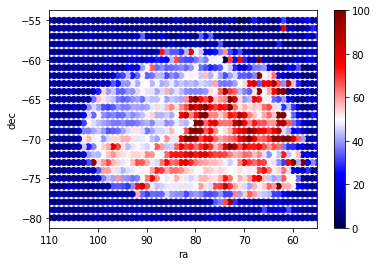

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_xlim([110,55])
sc = ax.scatter(acat['ra'],acat['dec'],c=1/acat['parallax'], vmin=0, vmax=100, cmap=plt.cm.seismic)
fig.colorbar(sc)

In [16]:
dists=1/(acat['parallax'].ravel()[cutind1])
avgdist=np.median(dists)
print (avgdist)

48.947181982396756


In [19]:
acat['parallax_error']

array([[0.18648786, 0.20009468, 0.19950249, ..., 0.21413431, 0.21390288,
        0.18013607],
       [0.18553998, 0.20393752, 0.19457111, ..., 0.16340529, 0.18663706,
        0.21187762],
       [0.18673008, 0.19347728, 0.21732483, ..., 0.20636065, 0.17267151,
        0.17299071],
       ...,
       [0.17578366, 0.17373636, 0.18208715, ..., 0.18569291, 0.19841296,
        0.18859267],
       [0.18141673, 0.17382998, 0.1839098 , ..., 0.19442165, 0.19770126,
        0.19934543],
       [0.17499005, 0.17404249, 0.18069606, ..., 0.19254785, 0.19732259,
        0.19523089]])